In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import periodogram, stft, firwin, welch, correlate
import scipy.io

from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

In [112]:
data = np.array([scipy.io.loadmat(f's{subject}.mat')['train'][:, :9, :, :] for subject in range(4, 13)])#Discard non-EEG channels (9+)
num_subjects, num_targets, num_channels, N, num_trials = data.shape
fs = 256
T_pre, T, T_post = 0.290, 4.000, 0.062

print(f"Classes:           {num_targets}")
print(f"EEG Channels:      {num_channels}")
print(f"Time Samples:      {N}")
print(f"Trials per Class:  {num_trials}")

Classes:           12
EEG Channels:      9
Time Samples:      1114
Trials per Class:  15


In [130]:
#hilbert, then instantaneous frequencies
# forecast incoming frequencies 
#
data.shape

(9, 12, 9, 1114, 15)

In [34]:
ch = 2
target = 0

In [74]:

t[-16]

4.0

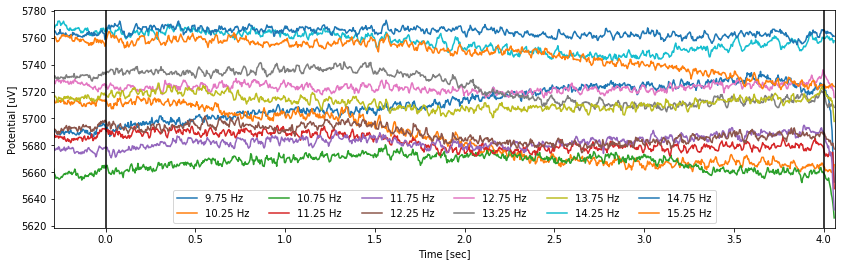

In [35]:
epoch_avgs = data.mean(axis=3) #axis 3 is num_trials, this gives us average of each class
t = [x/fs for x in range(-74, -74+N)] #t is time vector

plt.figure(figsize=(14, 4))
for ix, freq in enumerate([9.75 + 0.5 * x for x in range(num_targets)]): 
    plt.plot(t, epoch_avgs[ix, ch, :], label=f"{freq} Hz")
plt.xlim(-T_pre, T + T_post)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
plt.legend(loc='lower center', ncol=6)
plt.axvline(x=0, color='black');
plt.axvline(x=T, color='black');

(9, 12, 9, 1114, 15)


(9, 12, 9, 1114, 15)

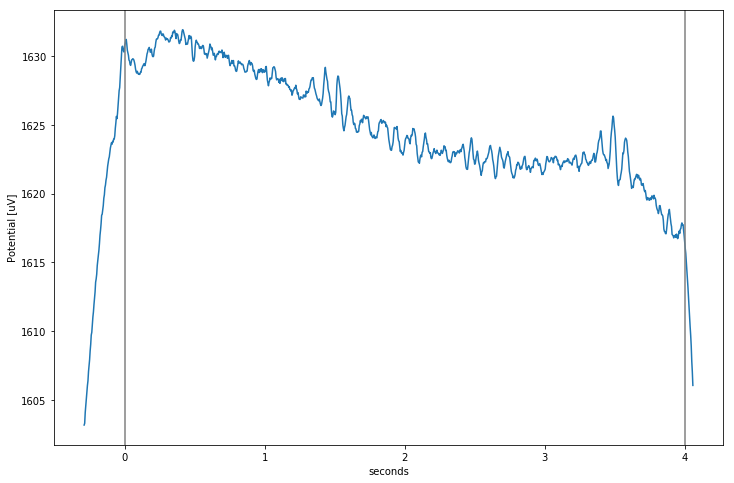

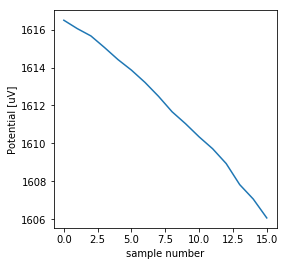

In [125]:
print(data.shape)
plt.figure(figsize=(12, 8))

# Averaing over all 12 tiles, across 15 trials, and every time-series in a single
plt.plot(t, data.mean(axis=0).mean(axis=3).mean(axis=1).mean(axis=0)) # deflection: ERP after stimulus disappear
plt.xlabel('seconds');plt.ylabel('Potential [uV]')
plt.axvline(x=0, color='gray')
plt.axvline(x=4.0, color='gray')


plt.figure(figsize=(4, 4))
plt.plot(data.mean(axis=0).mean(axis=3).mean(axis=1).mean(axis=0)[-16:])
plt.xlabel('sample number');plt.ylabel('Potential [uV]')
#data.mean(axis=0)[0]
data.shape



1.0
1628.8775312928667


numpy.ndarray

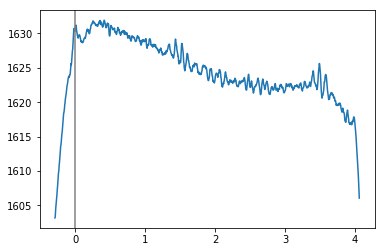

In [202]:
plt.plot(t, data.mean(axis=0).mean(axis=3).mean(axis=1).mean(axis=0)) # deflection: ERP after stimulus disappear

#print(data.mean(axis=0).mean(axis=3).mean(axis=1).mean(axis=0)[200])
print(t[330])
plt.axvline(x=0, color='gray')

print(data.mean(axis=0).mean(axis=3).mean(axis=1).mean(axis=0)[330])

data.mean(axis=0).mean(axis=3).mean(axis=1).mean(axis=0)[0]

temp = data.mean(axis=0).mean(axis=3).mean(axis=1).mean(axis=0)[:331]

type(temp)

(9, 12, 9, 1114, 15)


(-25, 25)

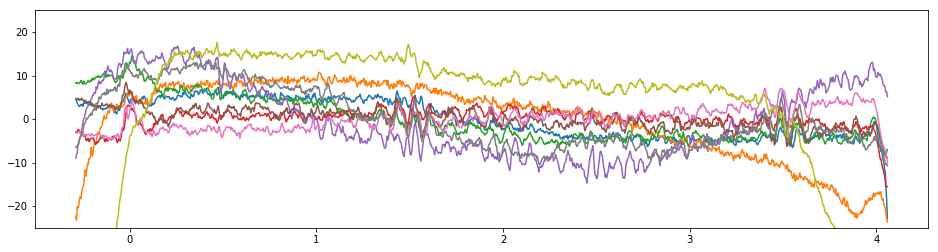

In [201]:
print(data.shape)
X = data.mean(axis = (1,2,4))
plt.figure(figsize=(16, 4))
for x in X:
    plt.plot(t, x - x.mean(axis=0)) # deflection: ERP after stimulus disappear
plt.ylim(-25, 25)

In [203]:
def best_fit(t_vector, potential):

    xbar = sum(t_vector)/len(t_vector)
    ybar = sum(potential)/len(potential)
    n = len(t_vector) 

    numerator = sum([xi*yi for xi,yi in zip(t_vector, potential)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in t_vector]) - n * xbar**2

    b = numerator / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b
best_fit([0,331],temp)



best fit line:
y = 1651.75 + -0.15x


(1651.7496457390555, -0.14632942244381988)

In [205]:
epochs = data[target, ch, :, :, :]

baselines = epochs[:74, :,:]
print(baselines.shape)
trials    = epochs[74:-16]
ends      = epochs[-16:]
plt.figure(figsize=(15, 3))
plt.plot(baselines - baselines.mean(axis = (1, 2)))
plt.xlim(0, 73); plt.ylim(-75, 75);

plt.figure(figsize=(3, 3))
plt.plot(ends - ends.mean(axis=0))
plt.xlim(0, 15); plt.ylim(-75, 75);


(9, 1114, 15)


ValueError: operands could not be broadcast together with shapes (9,1114,15) (9,) 

<Figure size 1080x216 with 0 Axes>

In [37]:
def xcorr(data1, data2, maxlag=100, zero_center=False):
    acf = np.zeros(maxlag)
    acf[0] = np.correlate(data1,data2)
    for lag in range(1,maxlag):
        acf[lag] = np.correlate(data1[:-lag],data2[lag:])
    
    acf /= acf[0]
    if zero_center: acf[0]=np.nan
    return acf

'''
def corr(x):
    x_corrected = x - x.mean()
    scale = x_corrected @ x_corrected
    x_corrected /= np.sqrt(scale)
    
    print(np.append(x_corrected, 0) @ np.insert(0, x_corrected))

corr(epochs[:, 0])    
'''

#plt.plot(epochs[:, 1])
#plt.figure()
#plt.plot(xcorr(epochs[:, 0], epochs[:,0]))

'\ndef corr(x):\n    x_corrected = x - x.mean()\n    scale = x_corrected @ x_corrected\n    x_corrected /= np.sqrt(scale)\n    \n    print(np.append(x_corrected, 0) @ np.insert(0, x_corrected))\n\ncorr(epochs[:, 0])    \n'

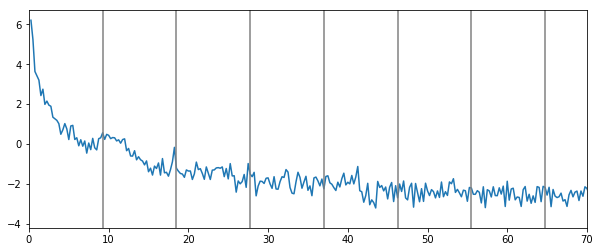

In [43]:
plt.figure(figsize=(10, 4))
plt.xlim(0, 70)

#f_baseline, Pxx_baselines = periodogram(baselines, fs=256, axis=0)
#plt.plot(f_baseline[1:], np.log(Pxx_baselines[1:]).mean(axis=1))

f_trial, Pxx_trials = periodogram(trials, fs=256, axis=0)
plt.plot(f_trial[1:], np.log(Pxx_trials[1:]).mean(axis=1));

h = 9.25 + 0.5 * target
plt.axvline(x=h, color='gray')
plt.axvline(x=h*2, color='gray')
plt.axvline(x=h*3, color='gray');plt.axvline(x=h*4, color='gray');
plt.axvline(x=h*5, color='gray');plt.axvline(x=h*6, color='gray')
plt.axvline(x=h*7, color='gray')

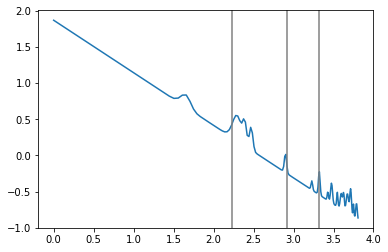

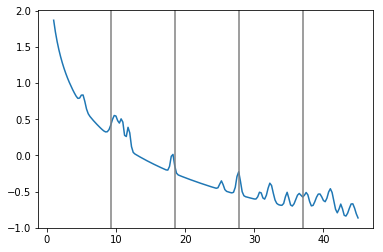

In [107]:
df = f_trial[1] - f_trial[0]
power_model = FOOOF(peak_width_limits=[2*df, 20], verbose=False)
power_model.fit(f_trial, Pxx_trials.mean(axis=1), freq_range=[1, 45])

plt.plot(np.log(power_model.freqs), power_model.fooofed_spectrum_);
plt.axvline(x=np.log(h), color='gray')
plt.axvline(x=np.log(h*2), color='gray')
plt.axvline(x=np.log(h*3), color='gray');

plt.figure()
plt.plot(power_model.freqs, power_model.fooofed_spectrum_);
plt.axvline(x=h, color='gray')
plt.axvline(x=h*2, color='gray')
plt.axvline(x=h*3, color='gray');plt.axvline(x=h*4, color='gray')

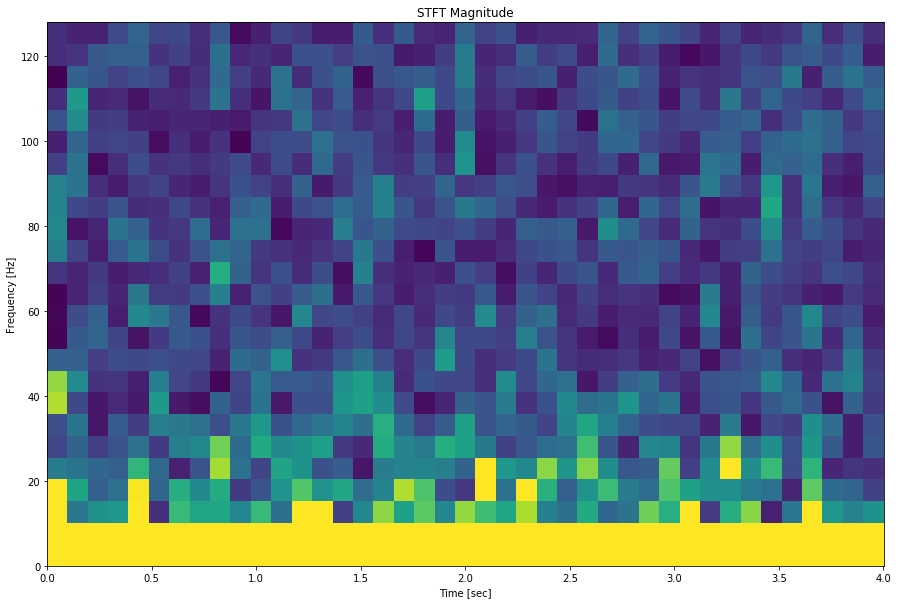

In [40]:
f_stft, t_stft, Zxx = stft(trials, fs, nperseg=50, axis=0, boundary='even')

amp = 2 * np.sqrt(2)
plt.figure(figsize=(15, 10))
plt.pcolormesh(t_stft, f_stft, np.abs(Zxx[:, 0, :]), vmin=0, vmax=amp) #Zxx.mean(axis=1)
plt.title('STFT Magnitude')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]');

In [41]:
# autocorrelation of 
# canonical component analysis

from muselsl import record

import os
filepath = os.path.join(os.getcwd(), '12hz.csv')

record(10, filepath)

In [27]:
# d = [
#     'test.csv',
#     '9hz.csv',
#     '12hz.csv',
#     'EEG_recording_2019-07-28-17.52.06.csv',
#     'EEG_recording_2019-07-28-19.31.57.csv',
#     'EEG_recording_2019-07-28-21.00.42.csv'
# ]
# data = pd.read_csv(d[0])
# data.timestamps -= data.timestamps[0]

# channels = ['AF7', 'AF8', 'TP9', 'TP10']

# aux_mean = data['Right AUX'].mean()
# data[channels] -= aux_mean

# N = data.shape[0]
# T = data.timestamps[N-1]
# fs = N / T
# print(f"Total samples: {N}")
# print(f"Sampling rate: {fs} Hz")

# fig, axes = plt.subplots(len(channels), figsize=(15, 3 * len(channels)))
# fig.subplots_adjust(hspace=0.6)
# for ax, ch in zip(axes, channels):
#     ax.set_xlim(0, T)
#     ax.title.set_text(f"Channel {ch}")
#     ax.plot(data.timestamps, data[ch])

FileNotFoundError: [Errno 2] File b'test.csv' does not exist: b'test.csv'

In [ ]:
# channel = data[channels[3]]

# f_pow, Pxx_pow = periodogram(channel, fs=fs, window='hann')
# plt.figure(figsize=(8, 4))
# plt.plot(f_pow, np.log(Pxx_pow), '.')
# plt.xlim(0, fs / 2)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Log Power');

In [ ]:
# cutoff = (59.6, 60.4)
# filt_order = 801
# filt_coefs = firwin(filt_order, cutoff, fs=fs, pass_zero=True)

# plt.figure(figsize=(15, 3))
# channel_filt = np.convolve(channel, filt_coefs, mode='same')

# plt.plot(channel)
# plt.plot(channel_filt)
# plt.xlim(0, 100)
# plt.ylim(-50, 50)

# f, Pxx = periodogram(channel_filt, fs=fs, window='hann')
# plt.figure(figsize=(8, 4))
# plt.plot(f, np.log(Pxx), '.')
# plt.xlim(0, fs / 2)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Log Power');

# f, Pxx = welch(channel_filt, fs=fs, window='hann')
# plt.figure(figsize=(8, 4))
# plt.plot(f, np.log(Pxx), '.')
# plt.xlim(0, fs / 2)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Log Power');

# f_stft, t_stft, Zxx = stft(channel_filt, fs, window='hann', nperseg=200)

# amp = 2 * np.sqrt(2)
# plt.figure(figsize=(15, 10))
# plt.pcolormesh(t_stft, f_stft, np.abs(Zxx), vmin=0, vmax=amp)
# plt.title('STFT Magnitude')
# plt.xlabel('Time [sec]')
# plt.ylabel('Frequency [Hz]');

In [ ]:
# def moving_average(a, n=3) :
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n
# k = 10
# f_smooth, P_smooth = periodogram(data['TP10'], fs)
# f_smooth = f_smooth[k-1:]
# P_smooth = moving_average(P_smooth, k)

# plt.figure(figsize=(10, 4))
# plt.plot(f_smooth, np.log(P_smooth), '-')
# plt.xlim(0, 65)
# plt.ylim(-10, 4)

In [ ]:
# from fooof import FOOOF

# #spectra = np.array([periodogram(data[ch], fs, 'hann')[1] for ch in ['AF7', 'AF8', 'TP9', 'TP10']])
# #model = FOOOFGroup(peak_width_limits=[0.2, 8.0], max_n_peaks=8, verbose=False)
# #model.fit(f_pow, spectra, freq_range=[3, 45])
# #model.get_results()[3].peak_params

# hzs = [20, 30, 40]

# #model = FOOOF(peak_width_limits=[0.5, 3.0], max_n_peaks=12)
# model = FOOOF()

# f_TP10, P_TP10 = periodogram(data['TP10'], fs)
# model.fit(f_TP10, P_TP10, freq_range=[3, 55])

# params = model.get_results().peak_params
# ixs = [np.argmax( -np.abs(params[:, 0] - hz) ) for hz in hzs]

# print(params[ixs])
# print(hzs[np.argmax( params[ixs][:, 1] )])

# model.report()

In [28]:
pip install fooof

Note: you may need to restart the kernel to use updated packages.
